# Testing for Variance Scale

In this notebook, I explore the comparison of two distributions from a control group and a treatment group. The treatment group has a much lower variance when compared to the control group, leading some in the lab to think the treatment is a success. However, Dr. Cudmore is skpetical, and believes the lowered variance is due to measurement error and/or lost of signal. Thus we search to find the following: is the variance difference of a linear shift or a multiplicative scale? If so, can we test for the significance of this? 

In [1]:
# Auto formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

In [126]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.stats as sp
import plotly.express as px
from IPython.display import display

import seaborn as sns

<IPython.core.display.Javascript object>

In [54]:
# We generate random data
rng = default_rng()
dist1 = rng.normal(0, 4, 1000)
dist2 = rng.normal(0, 2, 1000)

<IPython.core.display.Javascript object>

In [4]:
# Kolomogrov Smirnoff Test
sp.kstest(dist1, dist2)

KstestResult(statistic=1.0, pvalue=1.4508889103849681e-11)

<IPython.core.display.Javascript object>

In [57]:
# Approaching comparing variances with bootstrap approach
# np.var(dist1) - np.var(dist2)

var_sub = np.array([])
var_div = np.array([])
for i in range(1000):
    samp1 = rng.choice(dist1, size=1000, replace=True)
    samp2 = rng.choice(dist2, size=1000, replace=True)

    # print(np.var(samp1))
    # We get both the difference in variances (theta1) and the
    theta1 = np.var(samp1) - np.var(samp2)  # if same, should be centered around 0
    theta2 = np.var(samp1) / np.var(samp2)  # if same, should be centered around 1

    # Append both numpy array
    var_sub = np.append(var_sub, theta1)
    var_div = np.append(var_div, theta2)


fig1 = px.histogram(var_sub, title="Differences in Variances")
fig1.show()


fig2 = px.histogram(var_div, title="Proportionality of Variances")
fig2.show()

print(np.mean(var_sub))
print(np.mean(var_div))

12.090282004968484
4.112123464840391


<IPython.core.display.Javascript object>

When we have two distributions, we can compare for the difference in variances as well as the proportionality of the variances with a bootstrap. This can also allow us to create confidence intervals (multiple types, which I will elbaorate on later). If these variances are the same, we would expect that within a confidence interval for the differences we would see zero and with a proportionality of one. If these values are not contained in a confindence interval, we could then find how these variances differ. 

# Using Real Data

Moving on from simulation, now I will compare variances with bootstrap with some real data. First I will copy paste what was provided by Dr. cudmore, with the addition of reading the csv files from urls instead of file paths on a system, just a preference. 

In [7]:
# we can add to this as we get more data
pathList = []

# I changed this to urls so that it would be accesable from any device
# pathList.append("dataGianni/masterDb-jan-12-2022.csv")
# pathList.append("dataGianni/masterDb-jan-18-2022.csv")
# pathList.append("dataGianni/masterDb-feb-15-2022.csv")
pathList.append(
    "https://raw.githubusercontent.com/gspiga/Cudmore/main/VarAnalysis/gianni_var_analysis/dataGianni/masterDb-jan-12-2022.csv"
)
pathList.append(
    "https://raw.githubusercontent.com/gspiga/Cudmore/main/VarAnalysis/gianni_var_analysis/dataGianni/masterDb-jan-18-2022.csv"
)
pathList.append(
    "https://raw.githubusercontent.com/gspiga/Cudmore/main/VarAnalysis/gianni_var_analysis/dataGianni/masterDb-feb-15-2022.csv"
)


# make a list of dataframe (from csv files)
dfList = []
for fileIdx, path in enumerate(pathList):
    dfPath = pd.read_csv(path)
    dfPath["myFileIdx"] = fileIdx  # add for our book keeping if necc
    dfList.append(dfPath)

# make a single dataframe from all files in list
dfMaster = pd.concat(dfList, ignore_index=True)

<IPython.core.display.Javascript object>

In [8]:
# these are all the columns we have, some are useful and some are not
print(dfMaster.columns)

Index(['Unnamed: 0', 'analysisVersion', 'interfaceVersion', 'file',
       'detectionType', 'cellType', 'sex', 'condition', 'sweep',
       'sweepSpikeNumber', 'spikeNumber', 'include', 'userType', 'errors',
       'dvdtThreshold', 'mvThreshold', 'medianFilter', 'halfHeights',
       'thresholdPnt', 'thresholdSec', 'thresholdVal', 'thresholdVal_dvdt',
       'dacCommand', 'peakPnt', 'peakSec', 'peakVal', 'peakHeight',
       'timeToPeak_ms', 'preMinPnt', 'preMinVal', 'preLinearFitPnt0',
       'preLinearFitPnt1', 'earlyDiastolicDuration_ms', 'preLinearFitVal0',
       'preLinearFitVal1', 'earlyDiastolicDurationRate',
       'lateDiastolicDuration', 'preSpike_dvdt_max_pnt',
       'preSpike_dvdt_max_val', 'preSpike_dvdt_max_val2',
       'postSpike_dvdt_min_pnt', 'postSpike_dvdt_min_val',
       'postSpike_dvdt_min_val2', 'isi_pnts', 'isi_ms', 'spikeFreq_hz',
       'cycleLength_pnts', 'cycleLength_ms', 'diastolicDuration_ms', 'widths',
       'widths_10', 'widths_20', 'widths_50', 'wid

<IPython.core.display.Javascript object>

## Useful columns

```
myFileIdx: index of csv we were loaded
file: name of the file
condition: condiiton of recording from ('Control', 'TP')
thresholdSec: time of threshold
thresholdVal: value at threshold
peakSec: time of peak
peakVal: value at peak  # look at the variance
peakHeight: height of peak (peakVal - thresholdVal)
isi_ms: time between peak[i] and peak[i-1]
```

## Clean up the data

Replace conditon 'TG' with 'Thapsigargin'

In [17]:
condList = dfMaster["condition"].unique()
print(f"before condList:{condList}")

# do not do this
# dfMaster[ dfMaster['condition']=='TG' ]['condition'] = 'Thapsigargin'

# do this
dfMaster.loc[dfMaster["condition"] == "TG", "condition"] = "Thapsigargin"

condList = dfMaster["condition"].unique()
print(f"after condList:{condList}")

before condList:['Control' 'Thapsigargin' 'TG']
after condList:['Control' 'Thapsigargin']


<IPython.core.display.Javascript object>

## Plot stats in a table

In [29]:
# could set this to any column to get stats
colStr = "peakVal"

# a list of stats to take per 'file'
aggList = ["count", "min", "max", "mean", scipy.stats.sem, "median", "var"]

dfStats = dfMaster.groupby(["file", "condition", "myFileIdx"], as_index=False)[
    colStr
].agg(aggList)

print(f"stats for col: {colStr}")
display(dfStats)

stats for col: peakVal


,,,count,min,max,mean,sem,median,var
file,condition,myFileIdx,,,,,,,
2.5Hz_ctrl_0005.tif,Control,1,13,2.818897,3.118840,2.964127,0.027872,2.983678,0.010099
2.5Hz_ctrl_0009.tif,Control,1,8,2.607111,2.763000,2.690624,0.021312,2.689034,0.003634
2.5Hz_ctrl_0012.tif,Control,1,13,2.758010,3.176939,2.979535,0.040233,3.034222,0.021043
2.5Hz_ctrl_0017.tif,Control,1,9,1.787921,2.417780,2.304765,0.065323,2.362354,0.038404
2.5Hz_ctrl_0028.tif,Control,1,10,2.430220,2.687595,2.582455,0.026511,2.597892,0.007028
2.5Hz_thapsi_0024.tif,Thapsigargin,1,10,1.196586,1.292551,1.235665,0.009530,1.227982,0.000908
220110n_0003.tif,Control,0,10,1.912594,2.003728,1.957616,0.010250,1.965467,0.001051
220110n_0005.tif,Control,0,6,2.232398,2.412802,2.317046,0.028719,2.323407,0.004949
220110n_0009.tif,Control,0,5,2.588777,2.660828,2.621502,0.012971,2.618259,0.000841


<IPython.core.display.Javascript object>

This is where I will branch off a bit (I won't include the plots for sake of repetitvity). My first idea would be to split this data into two groups, by condition. 

In [127]:
# Data frame with only control group, using method for multilevel index
dfCont = dfStats[dfStats.index.isin(["Control"], level=1)]

# Data frame for Thapsigargin
dfThap = dfStats[dfStats.index.isin(["Thapsigargin"], level=1)]

display(dfCont.head())
display(dfThap.head())

,,,count,min,max,mean,sem,median,var
file,condition,myFileIdx,,,,,,,
2.5Hz_ctrl_0005.tif,Control,1,13,2.818897,3.118840,2.964127,0.027872,2.983678,0.010099
2.5Hz_ctrl_0009.tif,Control,1,8,2.607111,2.763000,2.690624,0.021312,2.689034,0.003634
2.5Hz_ctrl_0012.tif,Control,1,13,2.758010,3.176939,2.979535,0.040233,3.034222,0.021043
2.5Hz_ctrl_0017.tif,Control,1,9,1.787921,2.417780,2.304765,0.065323,2.362354,0.038404
2.5Hz_ctrl_0028.tif,Control,1,10,2.430220,2.687595,2.582455,0.026511,2.597892,0.007028


,,,count,min,max,mean,sem,median,var
file,condition,myFileIdx,,,,,,,
2.5Hz_thapsi_0024.tif,Thapsigargin,1,10,1.196586,1.292551,1.235665,0.009530,1.227982,0.000908
220110n_0055.tif,Thapsigargin,0,11,1.088367,1.127586,1.112524,0.004553,1.116809,0.000228
220110n_0060.tif,Thapsigargin,0,7,1.179083,1.224633,1.213991,0.005992,1.216600,0.000251
220110n_0064.tif,Thapsigargin,0,9,1.155473,1.212879,1.179186,0.006332,1.175165,0.000361
220110n_0067.tif,Thapsigargin,0,10,1.179756,1.226330,1.203072,0.005281,1.203729,0.000279


<IPython.core.display.Javascript object>

The big question: "Is the low variance (var) in 'Thapsigargin' condition simply due to the fact that the amplitude of the peak (mean) is small?" 

<AxesSubplot:xlabel='mean', ylabel='var'>

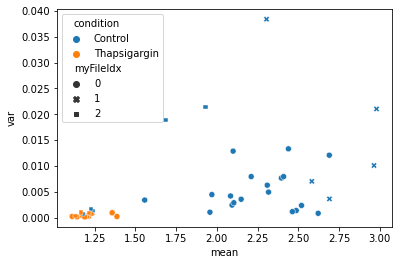

<IPython.core.display.Javascript object>

In [128]:
# hold off on using style='file', legend is too long and needs to be tweaked
# sns.scatterplot(x='mean', y='var', hue='condition', style='file', data=dfStats)

sns.scatterplot(x="mean", y="var", hue="condition", style="myFileIdx", data=dfStats)

First, I would like how the distributions of both the mean and the variance for both groups compare to each other. To do this, we perform a Two-Sample Kolmogrov-Smirnov ttest. Where we test, "What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?" $H_0$ is that these samples are drawn from the same distribution. 

In [129]:
# KS test for the mean
display(sp.kstest(dfCont["mean"], dfThap["mean"]))

# ... and for the variance
display(sp.kstest(dfCont["var"], dfThap["var"]))


KstestResult(statistic=0.896551724137931, pvalue=1.808314720186388e-09)

KstestResult(statistic=0.9310344827586207, pvalue=2.2632518081877606e-10)

<IPython.core.display.Javascript object>

These results would leave us to reject $H_0$ for both statistics with any reasonable level of $\alpha$, leaving us to conclude that both the mean and variance of these groups do not come from the same distribution. Now we are interested in bootstrapping for both mean and variance differences, both subtrating and multiplying.

In [161]:
# Lets look at what the distributions of this data actually looks like
display(
    px.histogram(dfCont["mean"], nbins=15, histnorm="probability", title="Control Mean")
)
display(
    px.histogram(
        dfThap["mean"], nbins=10, histnorm="probability", title="Thapsigargin Mean"
    )
)
display(
    px.histogram(
        dfCont["var"], nbins=15, histnorm="probability", title="Control Variance"
    )
)
display(
    px.histogram(
        dfThap["var"], nbins=10, histnorm="probability", title="Thapsigargin Variance"
    )
)

<IPython.core.display.Javascript object>

In [148]:
rng = default_rng(seed=12345)
mean_sub = np.array([])
mean_div = np.array([])
for i in range(1000):
    samp1 = rng.choice(dfCont["mean"], size=len(dfCont["mean"]), replace=True)
    samp2 = rng.choice(dfThap["mean"], size=len(dfThap["mean"]), replace=True)

    # print(np.var(samp1))
    # We get both the difference in variances (theta1) and the
    theta1 = np.mean(samp1) - np.mean(samp2)  # if same, should be centered around 0
    theta2 = np.mean(samp1) / np.mean(samp2)  # if same, should be centered around 1

    # Append both numpy array
    mean_sub = np.append(mean_sub, theta1)
    mean_div = np.append(mean_div, theta2)


fig1 = px.histogram(mean_sub, histnorm="probability", title="Mean Differences of Means")
fig1.show()


fig2 = px.histogram(
    mean_div, histnorm="probability", title="Mean Proportionality of Means"
)
fig2.show()

print(np.mean(mean_sub))
print(np.mean(mean_div))

0.975207787081232
1.800842526257547


<IPython.core.display.Javascript object>

In [142]:
var_sub = np.array([])
var_div = np.array([])


for i in range(1000):
    samp1 = rng.choice(dfCont["var"], size=len(dfCont["var"]), replace=True)
    samp2 = rng.choice(dfThap["var"], size=len(dfThap["var"]), replace=True)

    # print(np.var(samp1))
    # We get both the difference in variances (theta1) and the
    theta1 = np.mean(samp1) - np.mean(samp2)  # if same, should be centered around 0
    theta2 = np.mean(samp1) / np.mean(samp2)  # if same, should be centered around 1

    # Append both numpy array
    var_sub = np.append(var_sub, theta1)
    var_div = np.append(var_div, theta2)


fig1 = px.histogram(
    var_sub, histnorm="probability", title="Mean Differences in Variances"
)
fig1.show()


fig2 = px.histogram(
    var_div, histnorm="probability", title="Mean Proportionality of Variances"
)
fig2.show()

print(np.mean(var_sub))
print(np.mean(var_div))

0.007288439415740902
16.211727528583076


<IPython.core.display.Javascript object>

In [124]:
np.mean(
    rng.choice(dfCont["var"], size=10, replace=False)
    - 16.25835 * rng.choice(dfThap["var"], size=10, replace=False)
)

0.00041690755532308173

<IPython.core.display.Javascript object>

Next time: Make confidence intervals (different types for bootstraps) for each value of theta. 